# Data Processing

In [1]:
#Loading up all the packages

#Data structure / manipulation
import numpy as np
import pandas as pd

#Data visualization
import matplotlib.pyplot as plt

#The ML stuff
import tensorflow as tf
from tensorflow import keras
from keras.callbacks import EarlyStopping

#For file names (so we cna access them)
import os

#For a progress bar: 
from tqdm import tqdm

#For data processing
import sys
from skimage.io import imread
from skimage.transform import resize

In [2]:
#Creating these two folders
!mkdir stage1_train stage1_test

In [3]:
#Unzip it such that we can acutally use it. 
#Unzip (quite mode) from this link, it's a directory, and shove it into this folder
!unzip -q "../input/data-science-bowl-2018/stage1_train.zip" -d stage1_train/
print('done1')
!unzip -q "../input/data-science-bowl-2018/stage1_test.zip" -d stage1_test/
print('done2')

done1
done2


In [4]:
#We go throug the folders and just grab the names of the folders
train_ids = next(os.walk('./stage1_train'))[1]
test_ids = next(os.walk('./stage1_test'))[1]

In [5]:
#Checking to make sure we actually grabbed the ids
len(train_ids), len(test_ids)

(670, 65)

In [6]:
#Setting the variables up so we can use them again in the future
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3

In [7]:
#This code is the modified version of: https://colab.research.google.com/drive/1pKWf0rWvcFuhrvlQv4rvIPVEhd1nfc1c

#Let's pre-process the data (aka extract all the images and the masks 
#and make sure they're inthe right format to be able to be used by the model)

X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)

sys.stdout.flush()
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    path = './stage1_train/' + id_
    img = imread(path + "/images/" + id_ + '.png')[:,:,:IMG_CHANNELS]
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_train[n] = img
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
    for mask_file in next(os.walk(path + '/masks/'))[2]:
        mask_ = imread(path + '/masks/' + mask_file)
        mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant', 
                                      preserve_range=True), axis=-1)
        mask = np.maximum(mask, mask_)
    Y_train[n] = mask

# Get and resize test images
X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
sizes_test = []
print('Getting and resizing test images ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    path = './stage1_test/' + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    sizes_test.append([img.shape[0], img.shape[1]])
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_test[n] = img

print('Done!')

100%|██████████| 670/670 [07:40<00:00,  1.46it/s]

Getting and resizing test images ... 



100%|██████████| 65/65 [00:02<00:00, 30.97it/s]

Done!


# Machine Learning

We start building up the Convolutional DenseNet for Segementation: https://arxiv.org/pdf/1611.09326.pdf

In [8]:
#Idk what the real name for this is, 
#but it's the little convolutional block within the dense blocks
#Literally just BN, Activation, Conv, Dropout
def denselayer(x, filters=16):
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.ELU()(x)
    x = keras.layers.Conv2D(filters, (3, 3), kernel_initializer='he_normal', padding='same') (x)
    x = keras.layers.Dropout(0.5)(x)
    return x

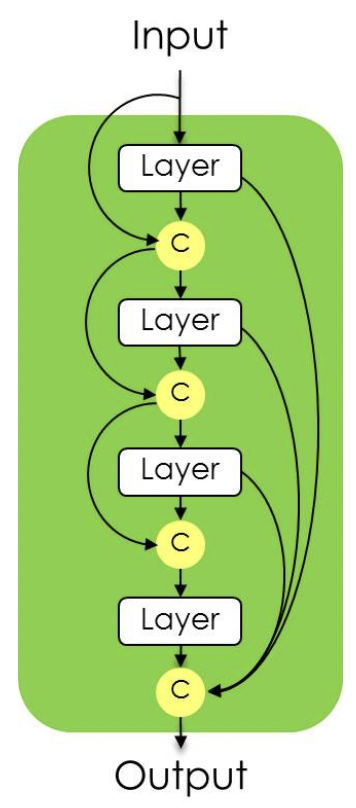

In [9]:
#Now we just chain 4 of them together and make sure 
#to do constant skip connections with the outputs to each other
def denseblock(x):
    l1 = denselayer(x)
    l2 = keras.layers.concatenate([l1, x])
    l2 = denselayer(l2)
    l3 = keras.layers.concatenate([l2, l1, x])
    l3 = denselayer(l3)
    l4 = keras.layers.concatenate([l3, l2, l1, x])
    l4 = denselayer(l4)
    return l4

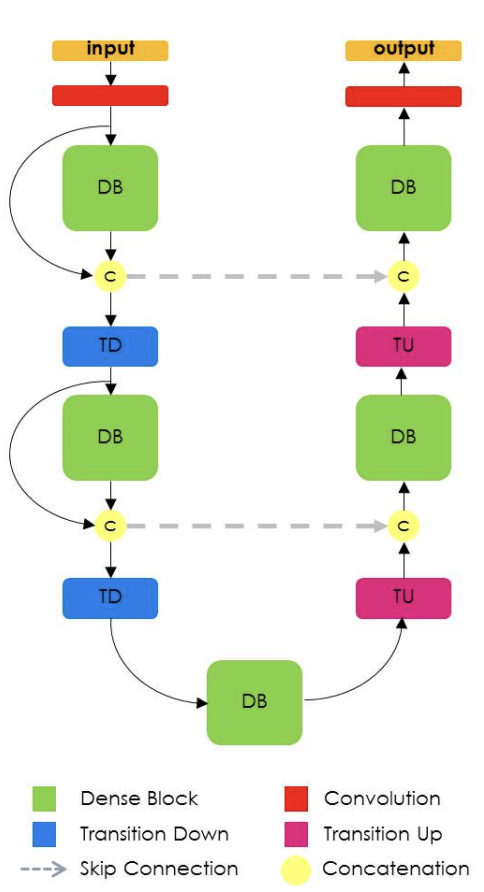

In [10]:
#Now I just replicate the whole archtechture presented in the paper:
inputs = keras.layers.Input((128, 128, 3))

normalized = keras.layers.Lambda(lambda x: x/255) (inputs)

first = keras.layers.Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (normalized)
dense1 = denseblock(first)
concat1 = keras.layers.concatenate([first, dense1])

second = keras.layers.MaxPool2D((2,2))(concat1)
dense2 = denseblock(second)
concat2 = keras.layers.concatenate([second, dense2])

third = keras.layers.MaxPool2D((2,2))(concat2)
dense3 = denseblock(third)

fourth = keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (dense3)
concat3 = keras.layers.concatenate([concat2, fourth])

dense5 = denseblock(concat3)
fifth = keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (dense5)
concat4 = keras.layers.concatenate([concat1, fifth])

dense6 = denseblock(concat4)

output = keras.layers.Conv2D(1, (1, 1), activation='sigmoid') (dense6)

In [11]:
#Linking up the chain and then getting an overview of the model
model = keras.models.Model(inputs = [inputs], outputs = [output])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 128, 128, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 16) 448         lambda[0][0]                     
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 128, 128, 16) 64          conv2d[0][0]                     
______________________________________________________________________________________________

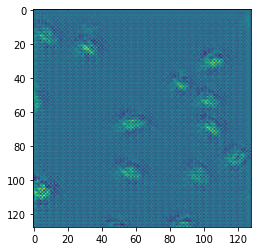

In [12]:
#What does the raw model look like
plt.imshow(model.predict(X_train[0:9])[0])

In [13]:
#Defining the mean Intersection of Union and then compiling the model to be fit for training
miou = tf.keras.metrics.MeanIoU(num_classes=2)
model.compile(optimizer='adam',loss='binary_crossentropy', metrics = miou)

In [14]:
#Running the model
earlystopper = EarlyStopping(patience=12, verbose=1)
model.fit(X_train,Y_train,batch_size=16,epochs=100, validation_split=0.1, callbacks = earlystopper)

Epoch 1/100
38/38 [==============================] - 11s 175ms/step - loss: 0.5802 - mean_io_u: 0.4000 - val_loss: 0.7820 - val_mean_io_u: 0.3940
Epoch 2/100
38/38 [==============================] - 4s 111ms/step - loss: 0.2996 - mean_io_u: 0.3978 - val_loss: 1.0021 - val_mean_io_u: 0.3940
Epoch 3/100
38/38 [==============================] - 4s 111ms/step - loss: 0.1990 - mean_io_u: 0.4027 - val_loss: 0.7394 - val_mean_io_u: 0.3940
Epoch 4/100
38/38 [==============================] - 4s 112ms/step - loss: 0.1579 - mean_io_u: 0.4051 - val_loss: 1.0623 - val_mean_io_u: 0.3940
Epoch 5/100
38/38 [==============================] - 4s 111ms/step - loss: 0.1324 - mean_io_u: 0.4041 - val_loss: 0.6740 - val_mean_io_u: 0.3940
Epoch 6/100
38/38 [==============================] - 4s 111ms/step - loss: 0.1458 - mean_io_u: 0.3990 - val_loss: 1.0570 - val_mean_io_u: 0.3940
Epoch 7/100
38/38 [==============================] - 4s 111ms/step - loss: 0.1270 - mean_io_u: 0.3985 - val_loss: 0.9907 - val_me

# Results

In [15]:
preds_train = model.predict(X_train, verbose=1)

21/21 [==============================] - 3s 79ms/step


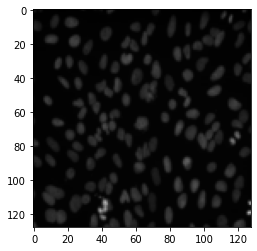

In [16]:
plt.imshow(X_train[25])

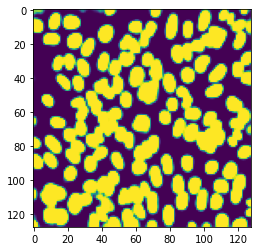

In [17]:
plt.imshow(preds_train[25])

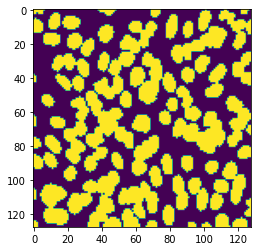

In [18]:
plt.imshow(Y_train[25])

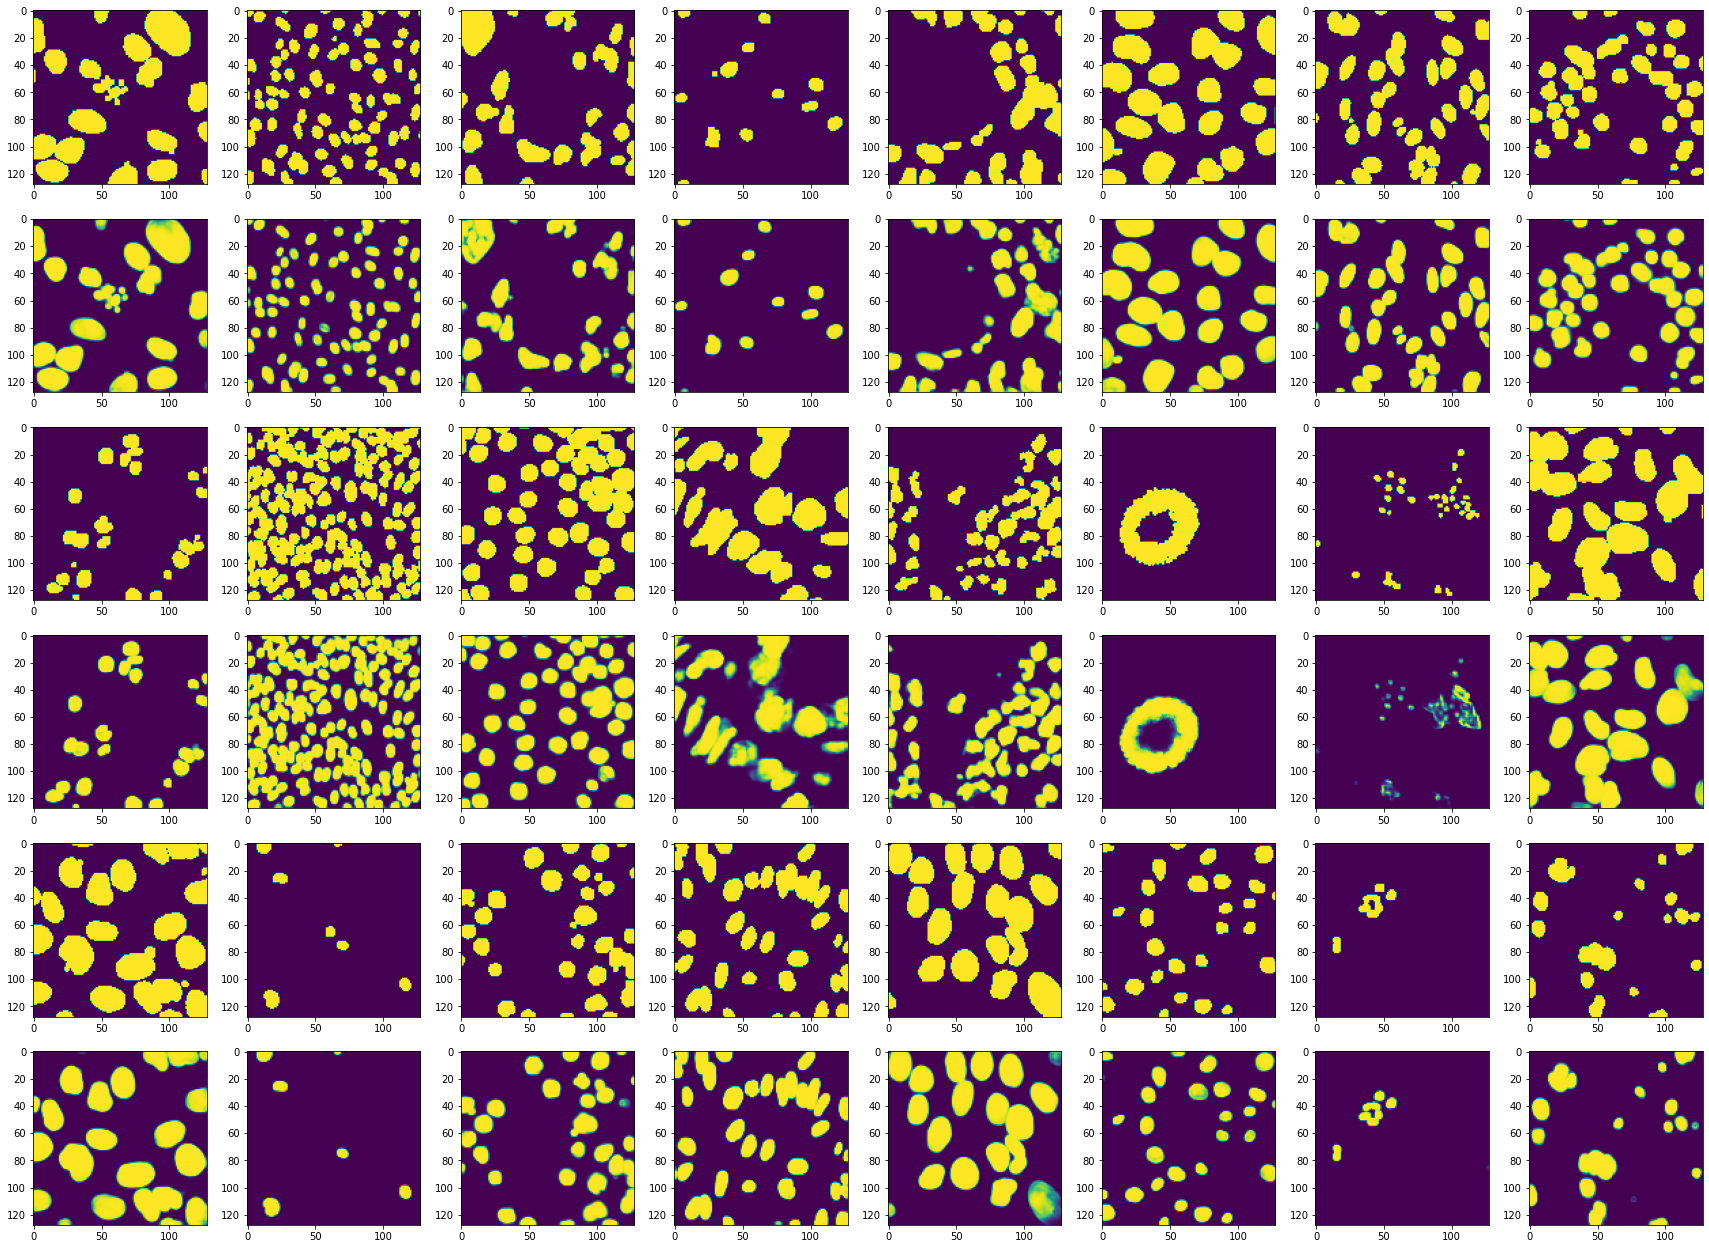

In [19]:
fig = plt.figure(figsize=(30,30))
for i in range(1, 9):
    fig.add_subplot(8, 8, i)
    plt.imshow(Y_train[i])
    fig.add_subplot(8, 8, i+8)
    plt.imshow(preds_train[i])

for i in range(9, 17):
    fig.add_subplot(8, 8, i+8)
    plt.imshow(Y_train[i])
    fig.add_subplot(8, 8, i+16)
    plt.imshow(preds_train[i])   

for i in range(17, 25):
    fig.add_subplot(8, 8, i+16)
    plt.imshow(Y_train[i])
    fig.add_subplot(8, 8, i+24)
    plt.imshow(preds_train[i]) 
plt.show()

In [20]:
preds_test = model.predict(X_test, verbose = 1)

3/3 [==============================] - 0s 145ms/step


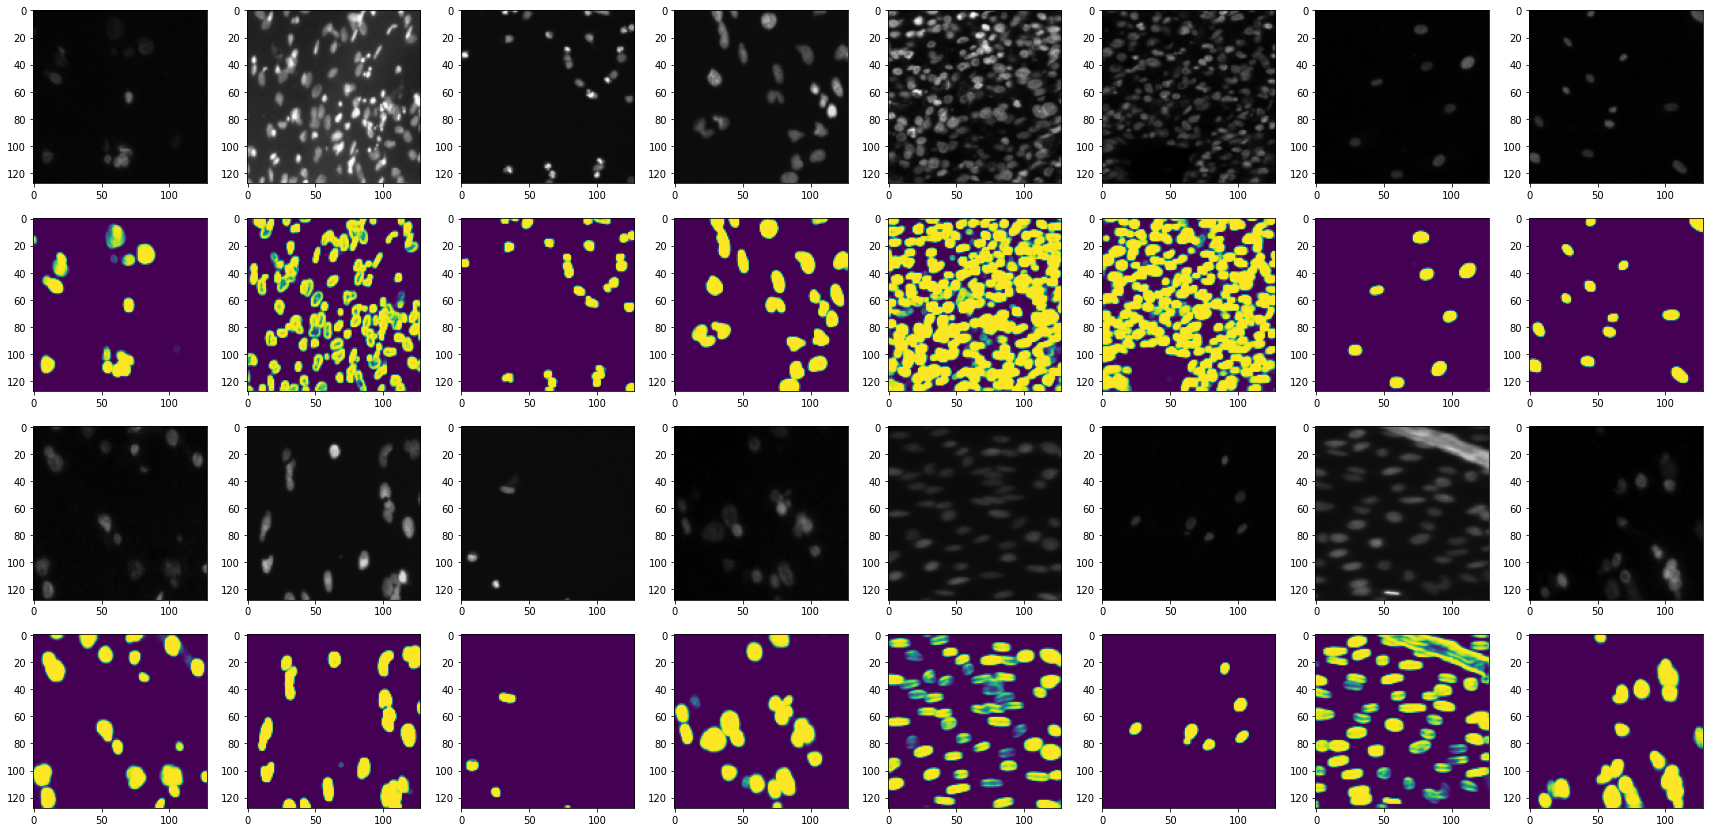

In [21]:
fig = plt.figure(figsize=(30,30))
for i in range(1, 9):
    fig.add_subplot(8, 8, i)
    plt.imshow(X_test[i])
    fig.add_subplot(8, 8, i+8)
    plt.imshow(preds_test[i])

for i in range(9, 17):
    fig.add_subplot(8, 8, i+8)
    plt.imshow(X_test[i])
    fig.add_subplot(8, 8, i+16)
    plt.imshow(preds_test[i])  

plt.show()